In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [3]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pytorchcv import train, plot_results

In [5]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [7]:
class VGG(nn.Module):
    def __init__(self, arch, lr = 0.1, num_classes = 10):
        super().__init__()
        self.arch = arch
        self.lr = lr
        self.num_classes = num_classes
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.LazyBatchNorm1d(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.LazyBatchNorm1d(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
    
    def forward(self, X):
        return self.net(X)

    def layer_summary(self, input_size):
        X = torch.randn(*input_size)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def apply_init(self, inputs, init = None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [8]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
data_train = datasets.FashionMNIST(
    root = './data',
    train = True,
    download = False,
    transform = trans
)

data_val = datasets.FashionMNIST(
    root = './data',
    train = False,
    download = False,
    transform = trans
)

In [9]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
net = VGG(arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
net.apply_init([next(iter(train_loader))[0]], init_cnn)
summary(net, input_size = [1,1,224,224])

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [1, 64, 112, 112]         --
│    └─Sequential: 2-2                   [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-5                  [1, 128, 112, 112]        73,856
│    │    └─BatchNorm2d: 3-6             [1, 128, 112, 112]        256
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [1, 128, 56, 56]          --
│    └─Sequential: 2-3                   [1, 256, 28, 28]          --
│    │  

In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train(net, train_loader, val_loader, optimizer = optimizer, epochs = 3, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.108, Val acc=0.111, Train loss=0.018, Val loss=0.018
Epoch  1, Train acc=0.374, Val acc=0.605, Train loss=0.012, Val loss=0.008
Epoch  2, Train acc=0.615, Val acc=0.711, Train loss=0.007, Val loss=0.006


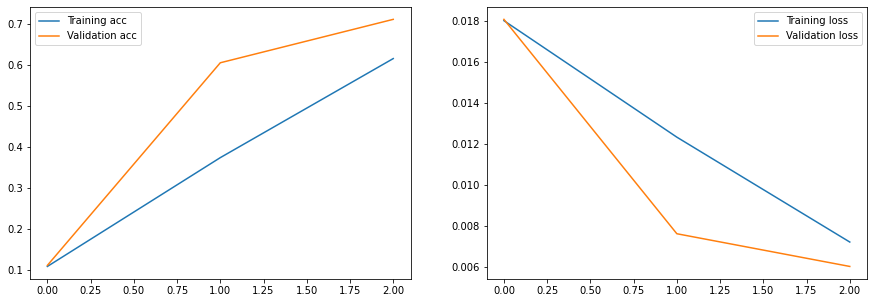

In [14]:
plot_results(hist)

In [15]:
#!wget https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py

In [16]:
import utils

Text(0.5, 1.0, 'label: 1')

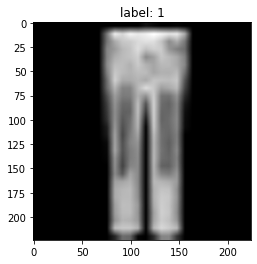

In [17]:
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(f'label: {label}')

In [18]:
prob = net(img.unsqueeze(0).to('cuda'))
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[6.6529e-04, 9.2771e-01, 2.5481e-08, 7.1587e-02, 2.8363e-07, 1.1944e-21,
         3.4999e-05, 5.2475e-26, 2.4781e-09, 1.8582e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-18-7fb306ad7e93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


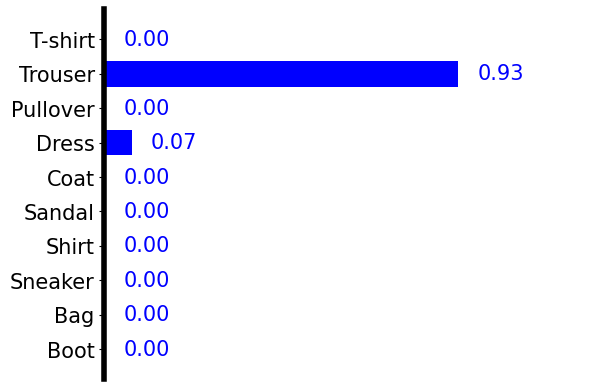

In [22]:
utils.show_prob_fashion_mnist(prob.to('cpu'))